# RateMe Scraping

Jesse Fredrickson 3/9/19

The purpose of this notebook is to scrape data from reddit - specifically, the r/rateme subreddit.

In [330]:
import praw
import pandas as pd
import numpy as np
import datetime as dt
import re
from statistics import mean, median
import json
import urllib.request
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Data Gathering
I am using [pushshift](https://github.com/pushshift/api) to query reddit for submissions, and praw to query reddit for the comments associated with those submissions

In [41]:
# Find these in the cred.txt file
reddit = praw.Reddit(client_id = 'u_OKrCFPlMzHjA',
                    client_secret = 'HIDDEN',
                    user_agent = 'rateme scrape',
                    username = 'ayylmao13',
                    password = 'HIDDEN')

subreddit = reddit.subreddit('rateme')

In [263]:
# custom functions for querying reddit with pushshift
# https://github.com/pushshift/api
def search_loop(df = None, epochs = 1, batch = 1000, num_comments = None):#startdate = str(time.time()).split('.')[0]):
    '''
    INPUTS:
    dataframe: dataframe to which I append (optional)
    epochs: number of iterations to run
    batch: number of returned submissions per run; default None (no limit)
    num_comments: number of comments to restrict search below. None = no limit
    
    Function which searches a subreddit and adds to a dataframe
    
    OUTPUT:
    dataframe of results
    '''
    x = 0
    while x < epochs:
        
        if df is not None:
            num_comments = df['top_comments'].apply(len).min()+1
        
        if num_comments is None:
            # create a url with no limit on comments
            url_dict = {'subreddit':'rateme',
                        'size':str(batch),
                        'fields':'title,url,id,created_utc',
                        'sort_type':'num_comments',
                        'sort':'desc'}
        else:
            # create a url with a limit on comments
            url_dict = {'subreddit':'rateme',
                        'size':str(batch),
                        'fields':'title,url,id,created_utc',
                        'sort_type':'num_comments',
                        'num_comments':'<'+str(num_comments),
                        'sort':'desc'}
        
        # Generate url
        url = gen_url(url_dict)
        
        # retrieve json object from pushshift
        dfx = search_fn(url, x)
        if df is None:
            df = dfx
        else:
            df = df.append(dfx, ignore_index = True)
            
        df.drop_duplicates(subset = ['id'], inplace = True)
        num_comments = df['top_comments'].apply(len).min()+1
        x+=1
    
    return df
        
def search_fn(url, x): # x is the run number
    
    print('starting epoch ' + str(x))
    print(url)
    
    response = urllib.request.urlopen(url)
    data = json.loads(response.read())
    pushshift_df = pd.io.json.json_normalize(data['data'])
    
    # use praw api to fetch top comments from submissions list and join them to submissions dataframe
    idlist = pushshift_df['id'].tolist()
    cflist = []
    i = 1
    for id_ in idlist:
        submission = reddit.submission(id=id_)
        print('retrieving comments for ' + str(i) + ' of ' + str(len(idlist)))
        # handle comments
        top_level_comments_list = []    
        for top_level_comment in submission.comments:#.replace_more(limit=0):
            if isinstance(top_level_comment, praw.models.MoreComments):
                continue
            top_level_comments_list.append(top_level_comment.body)
    
        # TODO: inplace comments parsing to reduce memory?
        cflist.append(top_level_comments_list)
        i += 1

    pushshift_df = pushshift_df.join(pd.Series(cflist, name = 'top_comments'))
    
    return pushshift_df

def gen_url(params_dict):
        url = 'https://api.pushshift.io/reddit/search/submission/?'
        q = ''
        for key, val in params_dict.items():
            s = key + '=' + val
            q = q + '&' + s
        url = url + q[1:]
        return url

In [270]:
# QUERY SUBMISSIONS AND COMMENTS
df = search_loop(epochs = 5, batch = 1000)

# TODO: currently sorting by most commented and then only accepting older in next epoch. Need to find better way to sort. Score?

print(df.shape)

starting epoch 0
https://api.pushshift.io/reddit/search/submission/?subreddit=rateme&size=1000&fields=title,url,id,created_utc&sort_type=num_comments&sort=desc
retrieving comments for 1 of 1000
retrieving comments for 2 of 1000
retrieving comments for 3 of 1000
retrieving comments for 4 of 1000
retrieving comments for 5 of 1000
retrieving comments for 6 of 1000
retrieving comments for 7 of 1000
retrieving comments for 8 of 1000
retrieving comments for 9 of 1000
retrieving comments for 10 of 1000
retrieving comments for 11 of 1000
retrieving comments for 12 of 1000
retrieving comments for 13 of 1000
retrieving comments for 14 of 1000
retrieving comments for 15 of 1000
retrieving comments for 16 of 1000
retrieving comments for 17 of 1000
retrieving comments for 18 of 1000
retrieving comments for 19 of 1000
retrieving comments for 20 of 1000
retrieving comments for 21 of 1000
retrieving comments for 22 of 1000
retrieving comments for 23 of 1000
retrieving comments for 24 of 1000
retrievin

In [271]:
# save progress to csv
df.to_csv('raw_scrape.csv', index = False)

In [262]:
# run if you want to use last saved query
df = pd.read_csv('raw_scrape.csv')
df.head()

,created_utc,id,title,url,top_comments
0,1526646432,8kcrrm,[21F] and never been kissed,https://imgur.com/a/WwwJNex,['Twist: She lives in an episode of Black Mirr...
1,1545930167,aa0x5c,"[30F] turning 31 tomorrow, rate me!",https://i.redd.it/w9rpgcrkqu621.jpg,"['https://imgur.com/a/mK0LJxa more pictures!',..."
2,1546540082,ac8ixy,(21F) Trying out crop tops for the first time ...,https://i.redd.it/0z1bhqu449821.jpg,"[""You're cute, but overweight. In my opinion,..."
3,1543856846,a2ql9g,[19 f] Always been interested in how others pe...,https://imgur.com/a/UAKbomd,['Beautiful. You look much better with the mor...
4,1370033606,1ffds6,ginger on the loose (f),http://i.imgur.com/hxGjnt9.jpg,"["" So it's like a full-on 70's porn down there..."


## Data Cleaning

In [272]:
df.describe()

,created_utc
count,3.000000e+03
mean,1.418491e+09
std,7.349045e+07
min,1.294211e+09
25%,1.352506e+09
50%,1.409740e+09
75%,1.480488e+09
max,1.552193e+09


In [244]:
df.isnull().sum()

created_utc     0
id              0
title           0
url             0
top_comments    0
dtype: int64

## Data Analysis

In [273]:
# Step 1: get ratings

# convert list of comments into text block
df['comment_block'] = df['top_comments'].apply(lambda x: ' '.join(x))

# extracts numerators of 10/10 format
x = df['comment_block'].str.extractall('(?:(1[0-9]|[1-9])(?:\.\d+)?/10)')
df['extracted_ratings'] = x.groupby(level=0)[0].apply(list)
# drop Nans
df = df.dropna(subset=['extracted_ratings'])

#convert to floats
df['extracted_ratings'] = df['extracted_ratings'].apply(lambda x: [float(i) for i in x])

In [331]:
# get mean ratings
df['mean'] = df['extracted_ratings'].apply(mean)
df['mean_int'] = df['mean'].apply(int)
df['median'] = df['extracted_ratings'].apply(median)
df['median_int'] = df['median'].apply(int)

# get ratings counts
df['ratings_count'] = df['extracted_ratings'].apply(len)

In [332]:
# Step 2: get age and gender info


if 'age' in df.columns:
    df = df.drop(['age'], axis = 1)
if 'gender' in df.columns:
    df = df.drop(['gender'], axis = 1)

# extract gender and age if of the format 19F or F19
# returns 3 columns 
x = df['title'].str.extract('(?:[(?:\(|\[)]\s*(?P<gender>[a-zA-Z])?\s*(?P<age>\d{2})\s*([a-zA-Z])?[(?:\)|\])])')
x['gender'] = x['gender'].fillna(x[2])
x['gender'] = x['gender'].str.upper()
x = x[['gender', 'age']]
df = df.join(x)

In [333]:
df['gender'].value_counts()

F    840
M    299
Name: gender, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F8AACACB38>]],
      dtype=object)

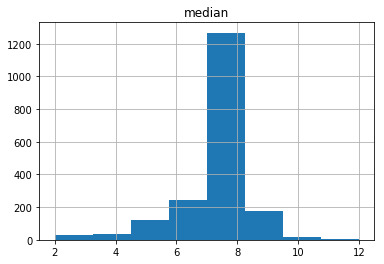

In [335]:
df.hist('median', bins = 8)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F8AB01D4E0>]],
      dtype=object)

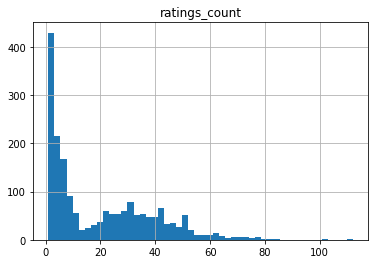

In [325]:
df.hist('ratings_count', bins = 50)

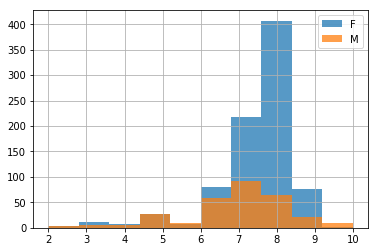

In [336]:
groups = df.groupby("gender")['median']

fig, ax = plt.subplots()

for k, v in groups:
    v.hist(label=k, alpha=.75, ax=ax)

ax.legend()

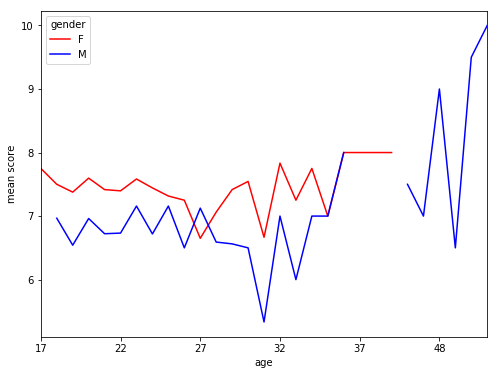

In [334]:
# get average rating by age for men and women
dfg = df.groupby(['gender', 'age'])
ax = dfg['median'].apply(mean).unstack(level=0).plot(figsize = (8,6), color=['r', 'b'])
ax.set_ylabel('mean score');

In [1]:
#df[df['mean'] == df['mean'].min()]['url'].tolist()